In [1]:
# import matplotlib as mpl
# mpl.use('Agg')
%matplotlib inline

import networkx as nx
import numpy as np
import random
import pandas as pd
from matplotlib import pyplot as plt
from itertools import combinations
from tqdm import tqdm
from joblib import Parallel, delayed

from graph_generator import grid_2d, add_p_and_delta
from ic import make_partial_cascade
from plot_utils import plot_snapshot, plot_query_process
from utils import infeciton_time2weight
from mwu import main_routine as mwu, MAX_MU, MAX_ADV, RANDOM
from synthetic_data import (load_data_by_gtype, GRID, KRONECKER_HIER, KRONECKER_PERI, KRONECKER_RAND,
                            PL_TREE, ER, BARABASI)

In [38]:
gtype = BARABASI
g, s2n_probas, node2id, id2node = load_data_by_gtype(gtype)
u, v = next(g.edges_iter())
infp = g[u][v]['p']
print('infp = {}'.format(infp))
if gtype == GRID:
    pos = {n: np.array(n) for n in g.nodes()}
else:
    pos = nx.spring_layout(g)

infp = 0.7


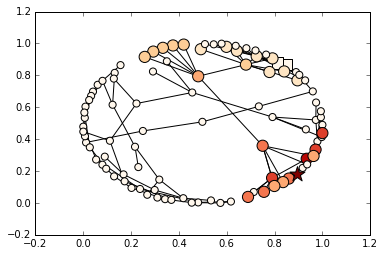

In [25]:
source, obs_nodes, infection_times, tree = make_partial_cascade(g, 0.05, sampling_method='late_nodes')

node2weight = infeciton_time2weight(infection_times)

plot_snapshot(g, pos, node2weight, 
              query_node=(3, 3),
              source_node=source,
              queried_nodes=obs_nodes, 
              max_node_size=500)

6
1 loop, best of 1: 71.1 ms per loop


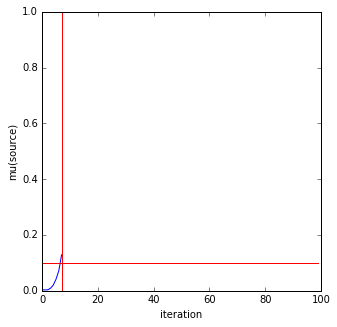

In [26]:
%%timeit -r 1 -n1
# demo of how mu(source increases)

source, obs_nodes, infection_times, tree = make_partial_cascade(
    g, fraction=0.05, sampling_method='late_nodes')
query_count, mu_list, query_list = mwu(g, node2id, id2node,
                                source, obs_nodes, infection_times, 
                                s2n_probas,
                                epsilon=0.7,
                                query_selection_method=MAX_MU,
                                check_neighbor_threshold=0.1,
                                save_log=True,
                                debug=False)
print(query_count)

mu_of_source = [mu[source] for mu in mu_list]
plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(mu_of_source)
ax.plot([0.1]*100, 'r')
ax.set_xlabel('iteration')
ax.set_ylabel('mu(source)')

idx = np.nonzero(np.array(mu_of_source) > 0.1)[0]
if len(idx) > 0:
    half_value = idx[0]
    ax.plot([half_value]*20, np.linspace(0, 1.0, 20), 'r')
# fig.savefig('figs/{}_mu_source_vs_iteration.pdf'.format(gtype))

2


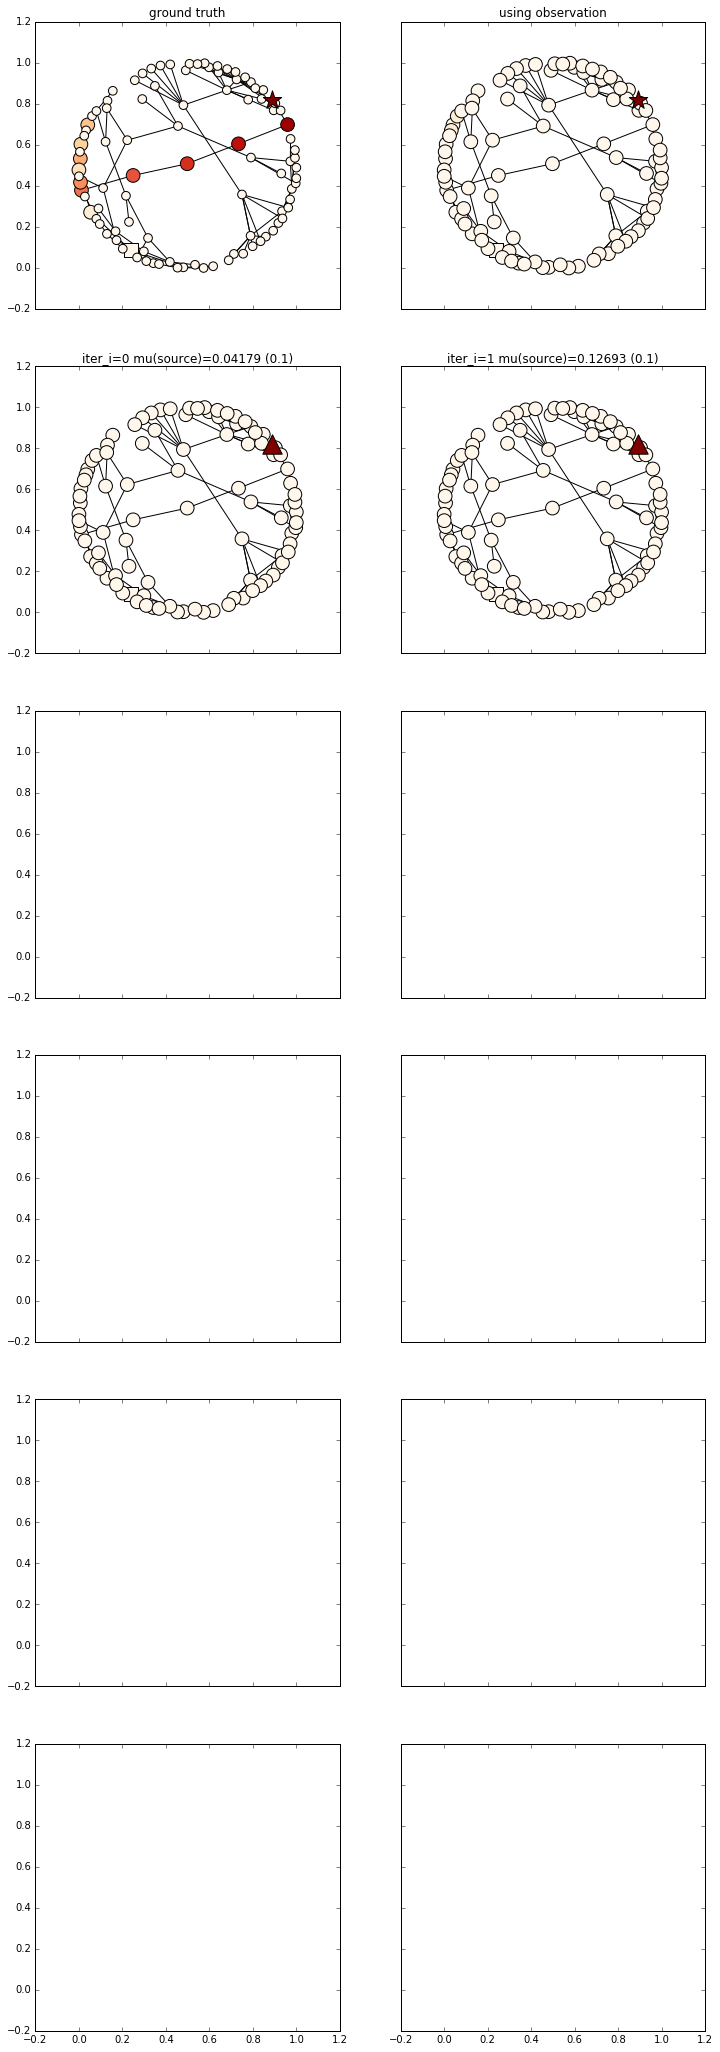

In [27]:
source, obs_nodes, infection_times, tree = make_partial_cascade(g, 0.05, sampling_method='late_nodes')
query_count, mu_list, query_list = mwu(g, node2id, id2node,
                                source, obs_nodes, infection_times, 
                                s2n_probas,
                                epsilon=0.7,
                                query_selection_method=MAX_MU,
                                check_neighbor_threshold=0.1,
                                max_iter=10,
                                save_log=True,
                                debug=False)
print(query_count)
fig, ax = plot_query_process(g, source, obs_nodes, infection_times,
                           mu_list, query_list,
                           check_neighbor_threshold=0.1,
                           pos=pos)

In [28]:
if False:
    print('|V|={}, |E|={}'.format(g.number_of_nodes(), g.number_of_edges()))
    if True:
        while True:
            source, obs_nodes, infection_times, tree = make_partial_cascade(
                g, fraction=0.05, sampling_method='late_nodes')    
            query_count, mu_of_source = mwu(g, source, obs_nodes, infection_times, 
                                            mean_times_by_source,
                                            epsilon=0.7,
                                            query_selection_method=MAX_MU,
                                            inspect_mu=False,
                                            debug=False, 
                                            plot=False)            
            if query_count > 50:
                print(query_count)
                break
    else:
        d = pkl.load(open('bad_examples/{}/1.pkl'.format(gtype), 'rb'))
        source, obs_nodes, infection_times = d['source'], d['obs_nodes'], d['infection_times']

    query_count, mu_of_source, fig = mwu(g, source, obs_nodes, infection_times, 
                                        times_by_source,
                                        source2nodeid_counter,
                                        epsilon=0.7,
                                        query_selection_method=MAX_MU,
                                        inspect_mu=False,
                                        debug=False, 
                                        plot=True,
                                        max_plots=12)
    print(query_count)
    fig.savefig('figs/query_process_{}'.format(gtype))

    plt.clf()
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(mu_of_source)
    ax.plot([0.1]*100, 'r')
    ax.set_xlabel('iteration')
    ax.set_ylabel('mu(source)')

    idx = np.nonzero(np.array(mu_of_source) > 0.1)[0]
    if len(idx) > 0:
        half_value = idx[0]
        ax.plot([half_value]*20, np.linspace(0, 1.0, 20), 'r')
    fig.savefig('figs/mu_vs_time_{}'.format(gtype))    


In [29]:
# dump bad example
if False:
    import os    
    data = {
        'source': source, 'obs_nodes': obs_nodes, 'infection_times': infection_times, 
        'tree': tree,
        'epsilon': 0.7,
        'query_selection_method': MAX_MU
    }
    if not os.path.exists('bad_examples/{}'.format(gtype)):
        os.makedirs('bad_examples/{}'.format(gtype))
    pkl.dump(data, open('bad_examples/{}/unsual_tree.pkl'.format(gtype), 'wb'))


In [39]:
def experiment_multiple_rounds(rounds, g,
                               node2id, id2node,
                               s2n_probas,
                               infp, fraction, epsilon, sampling_method, 
                               query_selection_method,
                               check_neighbor_threshold,
                               max_iter=float('inf'),
                               seed=None):
    np.random.seed(seed)
    random.seed(seed)
    results = []
    for i in tqdm(range(rounds)):
        source, obs_nodes, infection_times, tree = make_partial_cascade(g, fraction, sampling_method=sampling_method)
        r = mwu(g, node2id, id2node, 
                source, obs_nodes, infection_times, 
                s2n_probas,
                epsilon,
                query_selection_method=query_selection_method,
                debug=False,
                max_iter=max_iter,
                save_log=False)
        results.append(r)
    return results

In [40]:
rounds = 100
infp = 0.7
fraction = 0.05
epsilon = infp
check_neighbor_threshold = 0.01
sampling_method = 'late_nodes'
params = {
    'infp': infp,
    'fraction': fraction,
    'sampling_method': sampling_method
}

In [48]:
results_summary_by_query_method = {}
results_by_query_method = {}
# methods = [CENTROID, MAX_MU,  RANDOM]
methods = [MAX_MU,  RANDOM]
for method in methods:
    cnts = experiment_multiple_rounds(rounds, g, 
                                      node2id, id2node,
                                      s2n_probas,
                                      infp, fraction, epsilon, sampling_method,
                                      query_selection_method=method,
                                      check_neighbor_threshold=check_neighbor_threshold,
                                      max_iter=g.number_of_nodes(),
                                      seed=123456)
    s = pd.Series(list(filter(lambda c: c != False, cnts)))
    results_summary_by_query_method[method] = s.describe().to_dict()
    results_by_query_method[method] = s.as_matrix()


 43%|████▎     | 43/100 [00:00<00:00, 69.99it/s]

no more nodes to query


100%|██████████| 100/100 [00:01<00:00, 79.72it/s]


In [42]:
from baselines import baseline_dog_tracker

baseline_cnts = []
for i in range(rounds):
    source, obs_nodes, infection_times, tree = make_partial_cascade(g, fraction, sampling_method=sampling_method)
    c = baseline_dog_tracker(g, obs_nodes, infection_times)
    baseline_cnts.append(c)
results_summary_by_query_method['dog'] = pd.Series(baseline_cnts).describe().to_dict()
results_by_query_method['dog'] = np.array(baseline_cnts)
result = pd.DataFrame.from_dict(results_summary_by_query_method)    

In [43]:
print('number of nodes: {}'.format(g.number_of_nodes()))

number of nodes: 100


In [44]:
result

,dog,max_adversarial,max_mu,random
25%,18.000000,14.000000,10.000000,16.75000
50%,24.000000,22.000000,15.000000,28.50000
75%,32.000000,43.000000,23.750000,43.00000
count,100.000000,100.000000,98.000000,100.00000
max,54.000000,86.000000,93.000000,92.00000
mean,25.070000,30.440000,21.020408,31.71000
min,11.000000,7.000000,5.000000,8.00000
std,9.126778,19.616176,17.947219,19.05245


In [45]:
import os
d = 'outputs/{}'.format(gtype)
if not os.path.exists(d):
    os.makedirs(d)
result.to_pickle('{}/performance_comparison.pkl'.format(d))

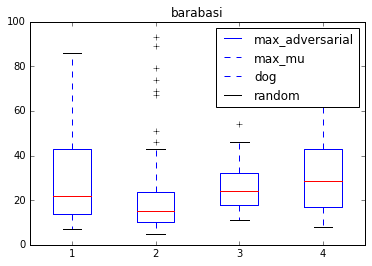

In [46]:
fig, ax = plt.subplots(1, 1)
data = list(results_by_query_method.values())
ax.boxplot(data)
ax.legend(list(results_by_query_method.keys()))
ax.set_title('{}'.format(gtype))
ax.set_ylim(0, g.number_of_nodes())
fig.savefig('figs/boxplot-{}'.format(gtype))

In [47]:
print(result.to_latex(float_format='%.2f'))

\begin{tabular}{lrrrr}
\toprule
{} &    dog &  max\_adversarial &  max\_mu &  random \\
\midrule
25\%   &  18.00 &            14.00 &   10.00 &   16.75 \\
50\%   &  24.00 &            22.00 &   15.00 &   28.50 \\
75\%   &  32.00 &            43.00 &   23.75 &   43.00 \\
count & 100.00 &           100.00 &   98.00 &  100.00 \\
max   &  54.00 &            86.00 &   93.00 &   92.00 \\
mean  &  25.07 &            30.44 &   21.02 &   31.71 \\
min   &  11.00 &             7.00 &    5.00 &    8.00 \\
std   &   9.13 &            19.62 &   17.95 &   19.05 \\
\bottomrule
\end{tabular}



In [ ]:
import sys
sys.exit(-1)

In [ ]:
if False:
    rounds = 500
    infp = 0.7
    fraction = 0.02
    epsilon = 0.8
    sampling_method = 'late_nodes'
    check_neighbor_threshold = 0.1
    
    # calling it outside 
    result = experiment_multiple_rounds(rounds, g, 
                                        mean_times_by_source,
                                        infp, fraction, epsilon, sampling_method,
                                        query_selection_method=MAX_MU,
                                        check_neighbor_threshold=check_neighbor_threshold)
    cnts, _ = zip(*result)
    print(np.mean(cnts))  # 10.252
    print(np.median(cnts)) # 8.0

    # calling it using parallel
    epsilons = [epsilon]
    results = Parallel(n_jobs=-1)(
        delayed(experiment_multiple_rounds)(rounds, g, 
                                            mean_times_by_source,
                                            infp, fraction, epsilon, sampling_method,
                                            query_selection_method='max_mu',
                                            check_neighbor_threshold=check_neighbor_threshold)
        for eps in epsilons)

    cnts, _ = zip(*results[0])
    print(np.mean(cnts))  # 14.208
    print(np.median(cnts))  # 11.0    

In [ ]:
epsilons = np.linspace(0.2, 0.9, 8)
# epsilons = [0.8]
results = []

for eps in tqdm(epsilons):
    result = experiment_multiple_rounds(rounds, g, 
                                        mean_times_by_source,
                                        infp, fraction, epsilon, sampling_method,
                                        query_selection_method='max_mu',
                                        check_neighbor_threshold=check_neighbor_threshold)
    results.append(result)    

In [ ]:
list_cnts = [list(zip(*result))[0] for result in results]
means = list(map(np.mean, list_cnts))
medians = list(map(np.median, list_cnts))
df = pd.DataFrame.from_dict({'eps': epsilons,
                             'mean': means, 
                             'median': medians})
df    

In [ ]:
from baselines import baseline_dog_tracker

baseline_cnts = []
for i in range(rounds):
    source, obs_nodes, infection_times, tree = make_partial_cascade(g, fraction, sampling_method=sampling_method)
    c = baseline_dog_tracker(g, obs_nodes, infection_times)
    baseline_cnts.append(c)

In [ ]:
pd.Series(baseline_cnts).describe().to_dict()

In [ ]:
print('mean', np.mean(baseline_cnts))
print('median', np.median(baseline_cnts))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax0, ax1 = axes
df.plot(x='eps', y=['mean'], ax=ax0)
ax0.plot([np.mean(baseline_cnts)] * len(epsilons))
ax0.legend(['multiplicative (max mu strategy)', 'baseline'])
ax0.set_ylim(0, 100)
ax0.set_title('mean')
ax0.set_ylabel('query count')

df.plot(x='eps', y=['median'], ax=axes[1])
ax1.plot([np.median(baseline_cnts)] * len(epsilons))
ax1.legend(['multiplicative (max mu strategy)', 'baseline'])
ax1.set_ylim(0, 100)
ax1.set_title('median')
ax1.set_ylabel('query count')

In [ ]:
fig.savefig('figs/grid-{}-{}.png'.format(sampling_method, fraction))

In [ ]:
df.to_pickle('outputs/mwu-{}-{}.pkl'.format(sampling_method, fraction))
import pickle
pd.Series(baseline_cnts).to_pickle('outputs/dog-{}-{}.pkl'.format(sampling_method, fraction))

In [ ]:
# summarize result
eps = 0.8
sampling_methods = ['uniform', 'late_nodes']
fraction = 0.02
for s in sampling_methods:
    s1 = pd.read_pickle('outputs/mwu-{}-{}.pkl'.format(s, fraction))
    s2_cnts = pd.read_pickle('outputs/dog-{}-{}.pkl'.format(s, fraction))
    print('method', s)
    print('mean', s1[s1['eps'] == 0.8].iloc[0]['mean'], np.mean(s2_cnts))
    print('median', s1[s1['eps'] == 0.8].iloc[0]['median'], np.median(s2_cnts))    
    print()